In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

In [2]:
pd.set_option('display.max_columns', None)
df = pd.read_json("/Users/timonikkila/projects/recare/testdataset/data/dataset_09.2018.json")

In [3]:
# Fast preliminary testing did not reveal too good pattern so some feature engineering might be useful
# My theory is that providers who accept often keeps accepting often and patients who are accepted often 
# will be accepted often.
#
# Input: Dataframe of original data
# Output: Dataframe has sorted by "request_sent" field. New fields "patient_success_rate" and 
# "provider_success_rate" are added. These fields contain the rate that patient was accepted and
# provider accepts offered patient.
def do_feature_engineering(df):
    def get_updated_stats(entity, entitys_stats, row):

        # update stats
        if entity not in entitys_stats.keys():
            entitys_stats[entity] = {"success": 0, "failure": 0}

        patient_stats = entitys_stats[entity]
        if row["request_status"] == 1:
            patient_stats["success"] += 1
        else:
            patient_stats["failure"] += 1

        return patient_stats

    def get_rate(stats):
        if stats["failure"] < 0.00000001:
            return 1.0
        else:
            return stats["success"] / (stats["failure"] + stats["success"])
        
    df["request_sent"] = pd.to_datetime(df["request_sent"],infer_datetime_format=True)
    df["patient_creation"] = pd.to_datetime(df["patient_creation"],infer_datetime_format=True)
    df["response_sent"] = pd.to_datetime(df["response_sent"],infer_datetime_format=True)
    df = df.sort_values(by=['request_sent']).reset_index(drop=True)

    patients_stats = {}
    patient_success_rate = [0.0] * df.shape[0]

    providers_stats = {}
    provider_success_rate = [0.0] * df.shape[0]

    for index, row in df.iterrows():
        patient_id = row["patient_id"]
        patient_stats = get_updated_stats(patient_id, patients_stats, row)
        patients_stats[patient_id] = patient_stats

        provider_id = row["provider_id"]
        provider_stats = get_updated_stats(provider_id, providers_stats, row)
        providers_stats[provider_id] = provider_stats

        patient_success_rate[index] = get_rate(patient_stats)
        provider_success_rate[index] = get_rate(provider_stats)

    df["patient_success_rate"] = patient_success_rate
    df["provider_success_rate"] = provider_success_rate
    
    return df

df = do_feature_engineering(df)


In [4]:
# Scaled between 0.0 and 1.0. Lets assume this is rough estimation of probability
def scale_to_prob(np_array):
    scaled_preds = (np_array - np_array.min()) 
    return scaled_preds/scaled_preds.max()


In [5]:
# Convert target value class to trainable value. 1.0 means success and 0.0 means failure. 
X, y = df.drop(["request_status"], axis=1),df["request_status"].apply(lambda x: 1.0 if x == 1 else 0.0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

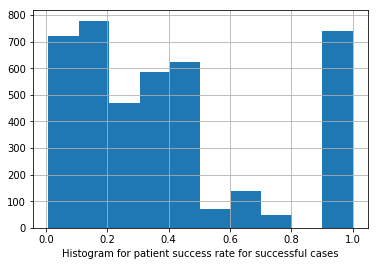

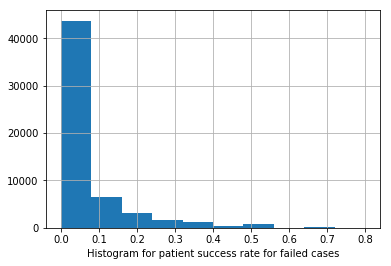

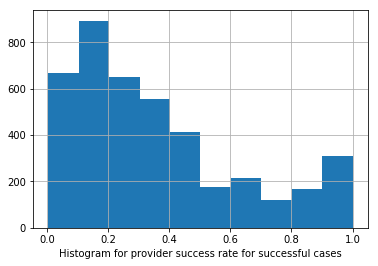

Text(0.5,0,'Histogram for provider success rate for failed cases')

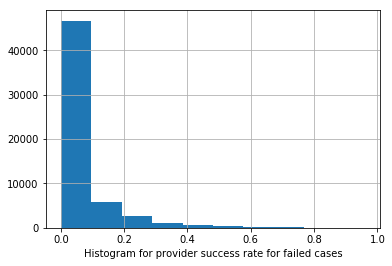

In [6]:
# split data to request_status = 1 and request_status != 1
accepted = df.loc[df['request_status'] == 1]
rejected = df.loc[df['request_status'] != 1]

accepted["patient_success_rate"].hist(bins=10)
plt.xlabel("Histogram for patient success rate for successful cases")
plt.show()
rejected["patient_success_rate"].hist(bins=10)
plt.xlabel("Histogram for patient success rate for failed cases")
plt.show()
accepted["provider_success_rate"].hist(bins=10)
plt.xlabel("Histogram for provider success rate for successful cases")
plt.show()
rejected["provider_success_rate"].hist(bins=10)
plt.xlabel("Histogram for provider success rate for failed cases")

### Histogram results
Based on histograms, it is clear that if patient's or provider's success rate is between 0.0 and 0.1 then it is very likely that patient gets rejected.

### Next steps
Lets do super simple LinearRegression. 
* First, normal LinearRegression
* Second, based on histograms, lets remove rows with success rate less than 0.15. Then do LinearRegression again.

Lets normalize predictions and treat that as **probability**. This is for sure not optimal, but good starting point

In [7]:
# Linear regression with all data
regr = linear_model.LinearRegression()

fields_for_lin = ["distance_to_patient_in_km", "patient_success_rate", "provider_success_rate"]
X_train_lin = X_train[fields_for_lin]
X_test_lin = X_test[fields_for_lin] 
# Train the model using the training sets
regr.fit(X_train_lin, y_train)
preds = regr.predict(X_test_lin)

scaled_preds = scale_to_prob(preds)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, scaled_preds))

print('Variance score: %.2f' % r2_score(y_test, scaled_preds))

print("Confusion matrix:")
converted_pred = (scaled_preds > 0.5).astype(int)
#tn, fp, fn, tp
confusion_matrix(y_test.values.astype(int), converted_pred)

Mean squared error: 0.04
Variance score: 0.41
Confusion matrix:


array([[11472,    12],
       [  570,   259]])

In [8]:
# Lets remove success rate between 0.0 and 0.15
# X_train, X_test, y_train, y_test
condition_train = (X_train["patient_success_rate"] > 0.15) & (X_train["provider_success_rate"] > 0.15)
condition_test = (X_test["patient_success_rate"] > 0.15) & (X_test["provider_success_rate"] > 0.15)
X_train_gt15 = X_train[condition_train]
y_train_gt15 = y_train[condition_train]
X_test_gt15 = X_test[condition_test]
y_test_gt15 = y_test[condition_test]

fields_for_lin = ["distance_to_patient_in_km", "patient_success_rate", "provider_success_rate"]
X_train_lin = X_train_gt15[fields_for_lin]
X_test_lin = X_test_gt15[fields_for_lin] 
# Train the model using the training sets
regr.fit(X_train_lin, y_train_gt15)
preds = regr.predict(X_test_lin)

scaled_preds = scale_to_prob(preds)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test_gt15, scaled_preds))

print('Variance score: %.2f' % r2_score(y_test_gt15, scaled_preds))

print("Confusion matrix:")
# threshold set as 0.34
converted_pred = (scaled_preds > 0.34).astype(int)
confusion_matrix(y_test_gt15.values.astype(int), converted_pred)

Mean squared error: 0.27
Variance score: -0.13
Confusion matrix:


array([[283,  30],
       [239, 250]])

### LinearRegression results
Model with all data is clearly learning something. If target is how often sent request were accepted, then error rate is rather high. This error rate can be brought down by removing patients and providers where accept rate has been historically very low. Of course this is not prodution ready solution, but it may help to optimize system.

### XGBoost
XGBoost is old timer Kaggle winner and it is relatively easy to try. So lets try it see if it works. 

To keep it simple, lets scale predictions between 0.0 and 1.0 and treat that as **probability**. This may not be optimal but will do for now.

In [9]:
# Pre-processing data for XGBoost
fields_for_gxb = ["distance_to_patient_in_km","solution", "patient_success_rate", "provider_success_rate"]
X_train_xgb = X_train[fields_for_gxb]
X_test_xgb = X_test[fields_for_gxb] 
# convert solution to one-hot. I am not sure if this is needed, but one web page suggested
X_train_xgb = X_train_xgb.join(pd.get_dummies(X_train_xgb["solution"])).astype(float).drop(["solution"],axis=1)
X_test_xgb = X_test_xgb.join(pd.get_dummies(X_test_xgb["solution"])).astype(float).drop(["solution"],axis=1)

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.05,
                max_depth = 5, alpha = 10, n_estimators = 500)
xg_reg.fit(X_train_xgb,y_train)
preds = xg_reg.predict(X_test_xgb)

scaled_preds = scale_to_prob(preds)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, scaled_preds))

print('Variance score: %.2f' % r2_score(y_test, scaled_preds))

print("Confusion matrix:")
converted_pred = (preds > 0.5).astype(int)
confusion_matrix(y_test.values.astype(int), converted_pred)


Mean squared error: 0.04
Variance score: 0.37
Confusion matrix:


array([[11427,    57],
       [  502,   327]])

### XGBoost results

Results are comparable to a case of LinearRegression.

### Next steps

This work was to get feel of the data. 

Next step could be to use deep learning and PyTorch. However starting with deep learning beforing having some touch of the data does not feel right. If implementing simple PyTorch deep learnign solution is needed, then I may have time to do it this weekend. Quick and dirty Linear layer solution would take few hours.

I actually wanted to test if PyTorch and Pyro combination would give good results. Pyro is probabilistic programming tool. It's output is mean and variance. So it would give quite good perspective for probability and how reliable predicted probability is. I have build one PyTorch + Pyro model before and it took 3 weeks full time. Of course now I could make it much faster, but it would still take long. 

https://pytorch.org/

http://pyro.ai


### About system used to develop

This is purely for debugging in a case scripts do not run in another environment.

In [10]:
%%bash
which python
python --version
pip freeze

/Users/timonikkila/anaconda3/bin/python
alabaster==0.7.10
anaconda-client==1.6.9
anaconda-navigator==1.7.0
anaconda-project==0.8.2
appnope==0.1.0
appscript==1.0.1
asn1crypto==0.24.0
astroid==1.6.1
astropy==2.0.3
attrs==17.4.0
Babel==2.5.3
backports.shutil-get-terminal-size==1.0.0
beautifulsoup4==4.6.0
bitarray==0.8.1
bkcharts==0.2
blaze==0.11.3
bleach==2.1.2
bokeh==0.12.13
boto==2.48.0
Bottleneck==1.2.1
certifi==2018.1.18
cffi==1.11.4
chardet==3.0.4
click==6.7
cloudpickle==0.5.2
clyent==1.2.2
colorama==0.3.9
conda==4.5.4
conda-build==3.4.1
conda-verify==2.0.0
contextlib2==0.5.5
cryptography==2.1.4
cycler==0.10.0
Cython==0.27.3
cytoolz==0.9.0
dask==0.16.1
datashape==0.5.4
decorator==4.2.1
distributed==1.20.2
docutils==0.14
entrypoints==0.2.3
et-xmlfile==1.0.1
fastcache==1.0.2
filelock==2.0.13
Flask==0.12.2
Flask-Cors==3.0.3
gevent==1.2.2
glob2==0.6
gluoncv==0.1.0
gmpy2==2.0.8
graphviz==0.8.3
greenlet==0.4.12
h5py==2.7.1
heapdict==1.0.0
html5lib==1.0.1
idna==2.6
imageio==2.2.0
imagesize=

Python 3.6.4 :: Anaconda, Inc.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
